In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import mpmath as mp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
# Set precision to 22 decimal places
mp.mp.dps = 22

In [3]:
# Load dataset
data = pd.read_csv("/kaggle/input/outage-probability-abc/outage_probability_high_precision.csv")

# Apply high precision to all relevant columns
data["ρt"] = data["ρt"].apply(mp.mpf)
data["ρ"] = data["ρ"].apply(mp.mpf)
data["σsr"] = data["σsr"].apply(mp.mpf)
data["ν"] = data["ν"].apply(mp.mpf)
data["Po|0"] = data["Po|0"].apply(mp.mpf)
data["Po|1"] = data["Po|1"].apply(mp.mpf)

# Normalize data using high precision
# Use min-max normalization for demonstration
def normalize_column(column):
    min_val = mp.mpf(min(column))
    max_val = mp.mpf(max(column))
    return [(mp.mpf(x) - min_val) / (max_val - min_val) for x in column]

data["ρt"] = normalize_column(data["ρt"])
data["ρ"] = normalize_column(data["ρ"])
data["σsr"] = normalize_column(data["σsr"])
data["ν"] = normalize_column(data["ν"])
data["Po|0"] = normalize_column(data["Po|0"])
data["Po|1"] = normalize_column(data["Po|1"])

# Convert to float64 for TensorFlow
data = data.astype("float64")

In [5]:
# Split into features and target
X = data[['ρt', 'ρ', 'σsr', 'ν']].values
y = data[['Po|0', 'Po|1']].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (float64-compatible scaler)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Set TensorFlow to use float64
tf.keras.backend.set_floatx('float64')

In [6]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicitly define the input shape
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    
    Dense(2, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/35


I0000 00:00:1733307006.243181      92 service.cc:145] XLA service 0x7d528801eed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733307006.243238      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733307006.243243      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   7/2460 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 1.5941 - mae: 1.0200  

I0000 00:00:1733307015.220913      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2460/2460 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0785 - mae: 0.1488 - val_loss: 8.4418e-04 - val_mae: 0.0208
Epoch 2/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0027 - mae: 0.0353 - val_loss: 5.7071e-04 - val_mae: 0.0186
Epoch 3/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.0014 - mae: 0.0253 - val_loss: 8.1619e-04 - val_mae: 0.0195
Epoch 4/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.1213e-04 - mae: 0.0198 - val_loss: 3.3790e-04 - val_mae: 0.0121
Epoch 5/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 5.9529e-04 - mae: 0.0161 - val_loss: 2.5301e-04 - val_mae: 0.0089
Epoch 6/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 4.6059e-04 - mae: 0.0142 - val_loss: 1.6068e-04 - val_mae: 0.0092
Epoch 7/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 3.4494e-04 - mae: 0.0121 - val_loss: 8.6691e-05 - val_mae: 0.0061
Epoch 8/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 2.9180e-04 - mae: 0.0110 - val_loss: 1.4796e-04 - 

In [8]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Save the model
model.save("complex_outage_probability_predictor.h5")

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.9497e-05 - mae: 0.0032
Test Loss: 1.9538805489185143e-05, Test MAE: 0.003187656858132913


In [11]:
model.save("complex_outage_probability_predictor.h5")

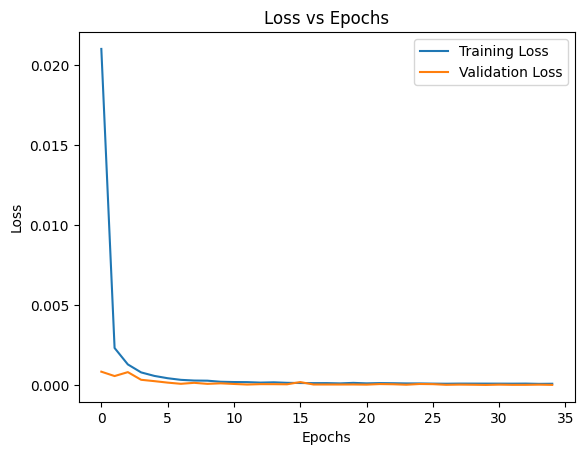

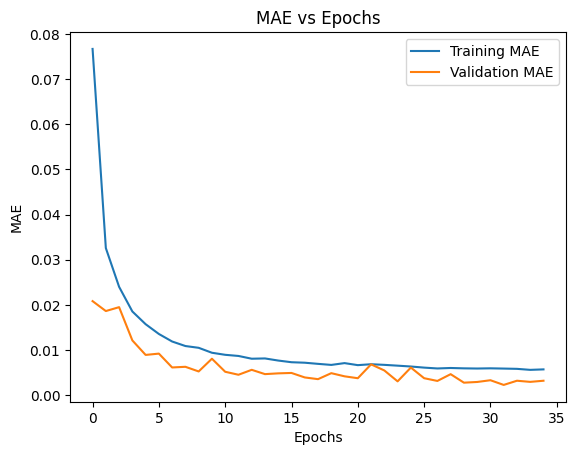

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


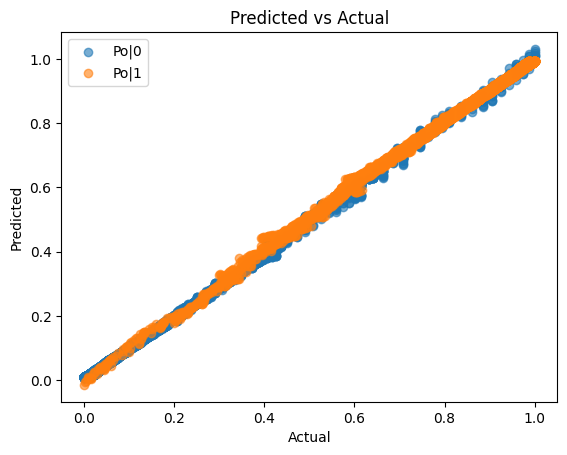

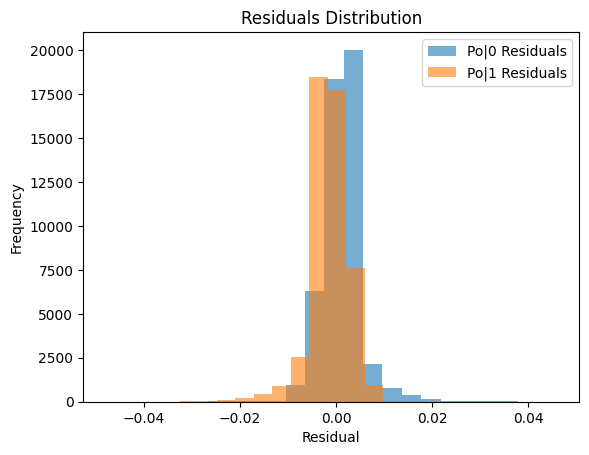

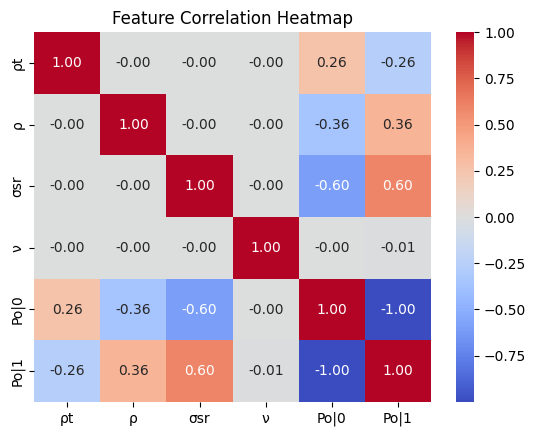

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


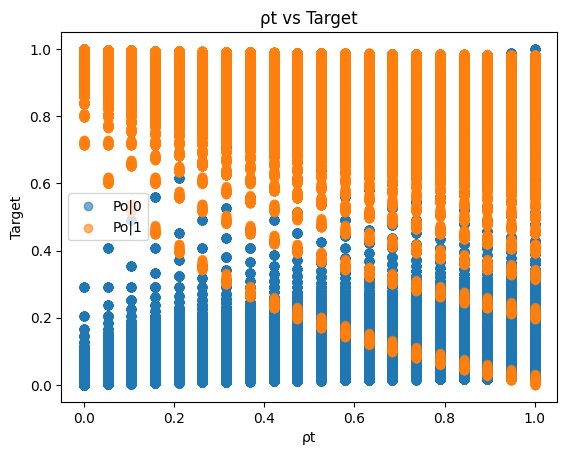

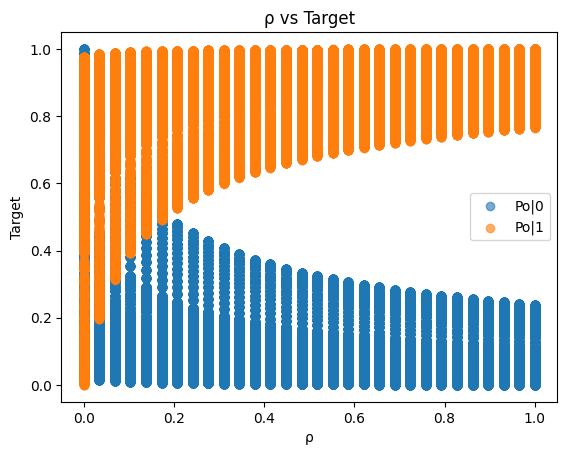

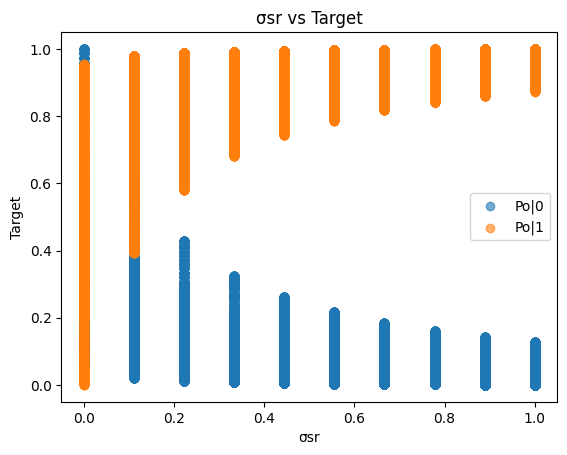

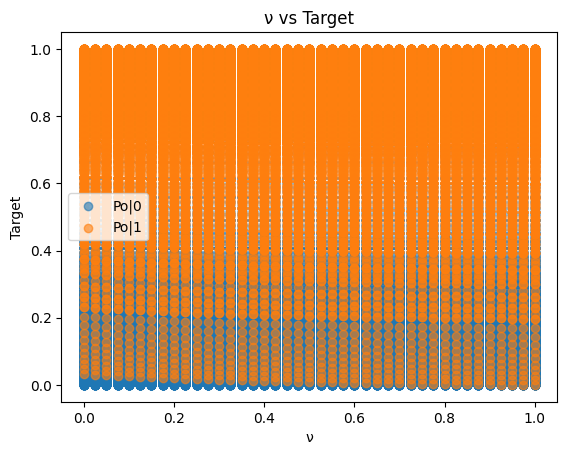

MSE for Po|0 in Percentage Terms: 0.2824%
MSE for Po|1 in Percentage Terms: 0.0025%


In [9]:
# 1. Plot Loss vs Epochs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Plot MAE vs Epochs
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 3. Predicted vs Actual (Test Set)
y_pred = model.predict(X_test)

plt.figure()
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.6, label='Po|0')
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.6, label='Po|1')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# 4. Residuals Distribution
residuals_p0 = y_test[:, 0] - y_pred[:, 0]
residuals_p1 = y_test[:, 1] - y_pred[:, 1]

plt.figure()
plt.hist(residuals_p0, bins=20, alpha=0.6, label='Po|0 Residuals')
plt.hist(residuals_p1, bins=20, alpha=0.6, label='Po|1 Residuals')
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 5. Feature Importance (Correlation Heatmap)
import seaborn as sns

correlation_matrix = data[['ρt', 'ρ', 'σsr', 'ν', 'Po|0', 'Po|1']].corr()
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# 6. Scatter Plots for Each Feature
features = ['ρt', 'ρ', 'σsr', 'ν']
for feature in features:
    plt.figure()
    plt.scatter(data[feature], data['Po|0'], alpha=0.6, label='Po|0')
    plt.scatter(data[feature], data['Po|1'], alpha=0.6, label='Po|1')
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.legend()
    plt.show()

# 7. MSE in Percentage Terms
mse_p0 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_p1 = mean_squared_error(y_test[:, 1], y_pred[:, 1])

# Convert to percentage relative to mean of actual values
percentage_mse_p0 = (mse_p0 / np.mean(y_test[:, 0]) ** 2) * 100
percentage_mse_p1 = (mse_p1 / np.mean(y_test[:, 1]) ** 2) * 100

print(f"MSE for Po|0 in Percentage Terms: {percentage_mse_p0:.4f}%")
print(f"MSE for Po|1 in Percentage Terms: {percentage_mse_p1:.4f}%")

Epoch 1/35
2458/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0275e-05 - mae: 0.0057 - val_r2_p0: 0.9969 - val_r2_p1: 0.9970
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 9.0272e-05 - mae: 0.0057 - val_loss: 3.0084e-05 - val_mae: 0.0035
Epoch 2/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9975e-05 - mae: 0.0054 - val_r2_p0: 0.9974 - val_r2_p1: 0.9978
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 7.9978e-05 - mae: 0.0054 - val_loss: 2.3499e-05 - val_mae: 0.0033
Epoch 3/35
2459/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7811e-05 - mae: 0.0055 - val_r2_p0: 0.9981 - val_r2_p1: 0.9981
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 7.7816e-05 - mae: 0.0055 - val_loss: 1.8715e-05 - val_mae: 0.0026
Epoch 4/35
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0541e-05 - mae: 0.0055 - val_r2_p0: 0.9987 - val_r2_p1: 0.9985
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 8.0541e-05 - mae: 0.0055 - val_loss: 1.3674e-05 - val_mae: 0.0021
Epoch 5/35
2460/

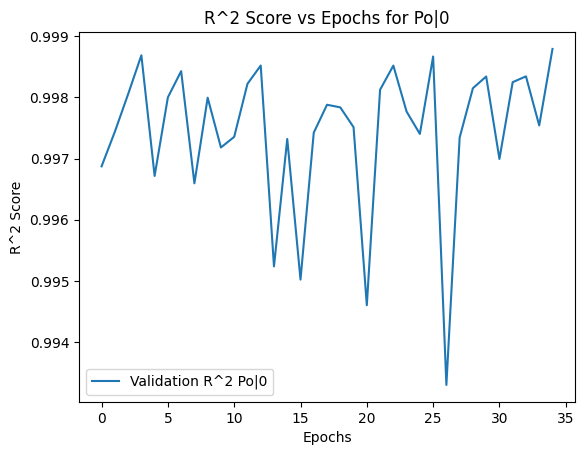

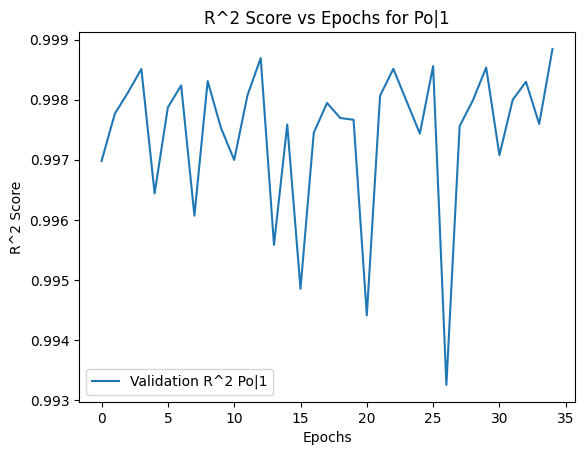

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Test R^2 Score for Po|0: 0.9988
Test R^2 Score for Po|1: 0.9989


In [17]:

import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Create custom callback for R^2
class R2History(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(R2History, self).__init__()
        self.validation_data = validation_data
        self.r2_scores_p0 = []
        self.r2_scores_p1 = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)
        r2_p0 = r2_score(y_val[:, 0], y_pred[:, 0])
        r2_p1 = r2_score(y_val[:, 1], y_pred[:, 1])
        self.r2_scores_p0.append(r2_p0)
        self.r2_scores_p1.append(r2_p1)
        print(f" - val_r2_p0: {r2_p0:.4f} - val_r2_p1: {r2_p1:.4f}")

# Split training data for validation
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize callback
r2_history = R2History(validation_data=(X_val, y_val))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_partial,
    y_train_partial,
    epochs=35,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[r2_history]
)

# Plot R^2 vs Epochs for Po|0
plt.figure()
plt.plot(r2_history.r2_scores_p0, label='Validation R^2 Po|0')
plt.title('R^2 Score vs Epochs for Po|0')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

# Plot R^2 vs Epochs for Po|1
plt.figure()
plt.plot(r2_history.r2_scores_p1, label='Validation R^2 Po|1')
plt.title('R^2 Score vs Epochs for Po|1')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

# Compute and print R^2 on test data
y_pred_test = model.predict(X_test)

r2_test_p0 = r2_score(y_test[:, 0], y_pred_test[:, 0])
r2_test_p1 = r2_score(y_test[:, 1], y_pred_test[:, 1])

print(f"Test R^2 Score for Po|0: {r2_test_p0:.4f}")
print(f"Test R^2 Score for Po|1: {r2_test_p1:.4f}")

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
R^2 Score for Po|0: 0.9988
R^2 Score for Po|1: 0.9989


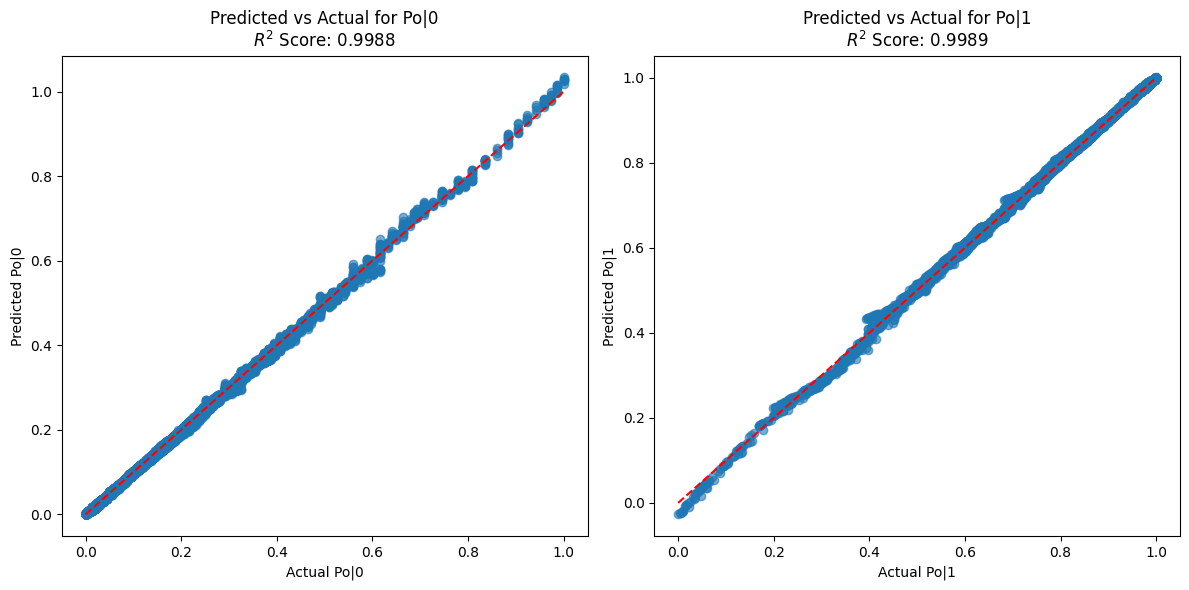

In [18]:
# 3. Predicted vs Actual (Test Set)
y_pred = model.predict(X_test)

# Compute R^2 scores
from sklearn.metrics import r2_score

r2_p0 = r2_score(y_test[:, 0], y_pred[:, 0])
r2_p1 = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"R^2 Score for Po|0: {r2_p0:.4f}")
print(f"R^2 Score for Po|1: {r2_p1:.4f}")

# Plot Predicted vs Actual with R^2 Score
plt.figure(figsize=(12, 6))

# Plot for Po|0
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.6)
plt.title(f'Predicted vs Actual for Po|0\n$R^2$ Score: {r2_p0:.4f}')
plt.xlabel('Actual Po|0')
plt.ylabel('Predicted Po|0')
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')  # Diagonal line

# Plot for Po|1
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.6)
plt.title(f'Predicted vs Actual for Po|1\n$R^2$ Score: {r2_p1:.4f}')
plt.xlabel('Actual Po|1')
plt.ylabel('Predicted Po|1')
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--')  # Diagonal line

plt.tight_layout()
plt.show()